# Explainability Metrics for Classification

In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from holisticai.explainability import Explainer
from holisticai.efficacy.metrics import classification_efficacy_metrics

## Data preprocessing

In [3]:
from holisticai.datasets import load_adult

# Dataset
dataset = load_adult()

# Dataframe
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0})
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1))
group = ["sex"]
group_a = df[group] == "Female"
group_b = df[group] == "Male"
data = [X, y, group_a, group_b]

# Train test split
dataset = train_test_split(*data, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]

<Axes: >

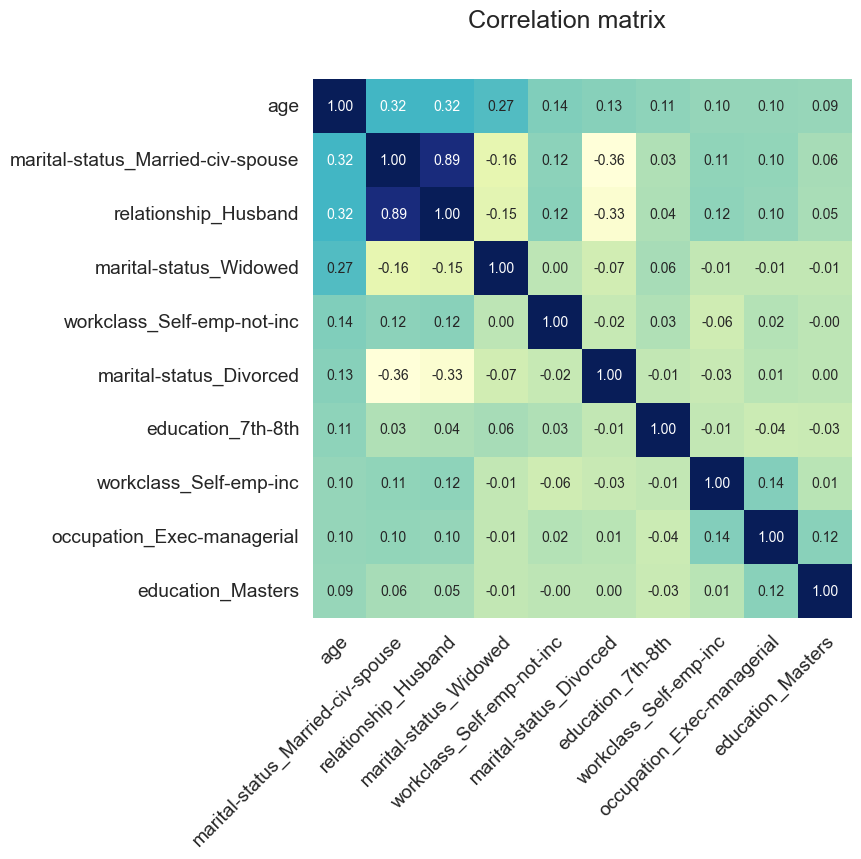

In [4]:
from holisticai.bias.plots import correlation_matrix_plot

correlation_matrix_plot(X, target_feature='age', size = (12,7))

## Model Training 

In [5]:
from sklearn.linear_model import LogisticRegression
import numpy as np
seed = np.random.seed(42) # set seed for reproducibility
# simple preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # train test split


model = LogisticRegression() # instantiate model
model.fit(X_train, y_train) # fit model

y_pred = model.predict(X_test) # compute predictions

# compute efficacy metrics
classification_efficacy_metrics(y_test, y_pred)

,Value,Reference
Metric,,
Accuracy,0.803665,1
Balanced Accuracy,0.618640,1
Precision,0.714781,1
Recall,0.270306,1
F1-Score,0.392269,1


# Global Explainability Metrics (based on Permutation Feature Importance)

In [6]:
# permutation feature importance
permutation_explainer = Explainer(based_on='feature_importance',
                      strategy_type='permutation',
                      model_type='binary_classification',
                      model = model, 
                      x = X_test, 
                      y = y_test)

In [7]:
permutation_explainer.metrics()

,Value,Reference
Metric,,
Fourth Fifths,0.775510,0
Spread Divergence,0.055241,-
Spread Ratio,0.987952,0
Position Parity,0.135946,1
Rank Alignment,0.860071,1
Region Similarity,0.960577,1
Explainability Ease,1.000000,1


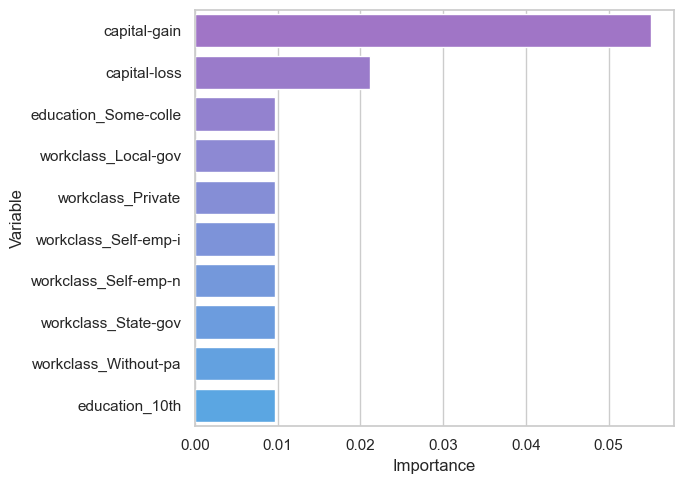

In [8]:
permutation_explainer.bar_plot(max_display=10)

In [9]:
permutation_explainer.metrics()

,Value,Reference
Metric,,
Fourth Fifths,0.775510,0
Spread Divergence,0.055241,-
Spread Ratio,0.987952,0
Position Parity,0.135946,1
Rank Alignment,0.860071,1
Region Similarity,0.960577,1
Explainability Ease,1.000000,1


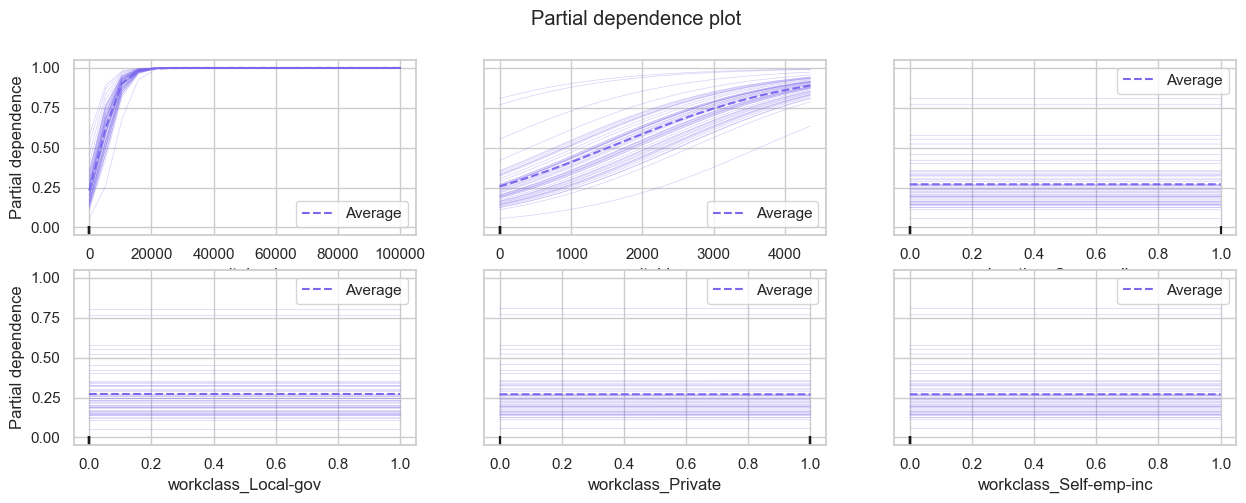

In [10]:
_,ax = plt.subplots(figsize=(15,5))
permutation_explainer.partial_dependence_plot(last=6, ax=ax, kind='both')

In [11]:
permutation_explainer.metrics(detailed=True)

,Value,Reference
Metric,,
Fourth Fifths,0.775510,0
Spread Divergence,0.055241,-
Spread Divergence [label=0],0.003363,-
Spread Divergence [label=1],0.064699,-
Spread Ratio,0.987952,0
Spread Ratio [label=0],0.999266,0
Spread Ratio [label=1],0.985889,0
Position Parity,0.135946,1
Position Parity [label=0],0.176642,1


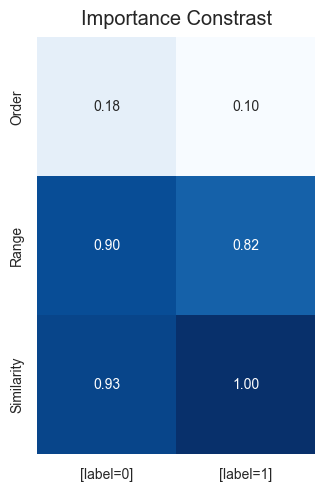

In [12]:
# Contrast Whole Importance vs. Group Importance
# -> Order -> mean positions
# -> Range -> match range of position 
# -> Similarity -> compute similarity
# -> e.g. we can see that Q0-Q1 and Q2-Q3 strong changes in their position but their importance weights maintains a high similarity with the whole model.
# -> e.g. we can see that Q1-Q2 and Q3-Q4 small changes in their position and their importance weights maintains a high similarity with the whole model.
permutation_explainer.contrast_visualization(show_connections=False)
# TODO separate show connections sin a second matrix

In [13]:
permutation_explainer.feature_importance_table(sorted_by='Global', top_n=5)

,Global Importance,[label=0] Importance,[label=1] Importance
Variable,,,
capital-gain,0.055144,0.014346,0.055993
capital-loss,0.021215,0.005362,0.029584
native-country_India,0.009699,0.010262,0.009489
native-country_Jamaica,0.009699,0.010262,0.009489
native-country_Dominican-Republic,0.009699,0.010262,0.009489


In [14]:
# surrogate feature importance
surrogate_explainer = Explainer(based_on='feature_importance',
                      strategy_type='surrogate',
                      model_type='binary_classification',
                      model = model, 
                      x = X_test, 
                      y = y_test)

In [15]:
surrogate_explainer.metrics()

,Value,Reference
Metric,,
Spread Divergence,3.792378,-
Spread Ratio,0.172867,0
Explainability Ease,0.994898,1
Surrogacy Efficacy,0.990890,1


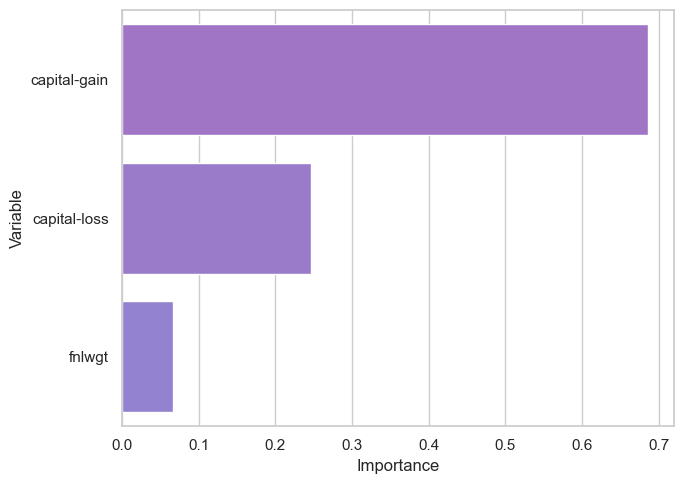

In [16]:
surrogate_explainer.bar_plot(max_display=3)

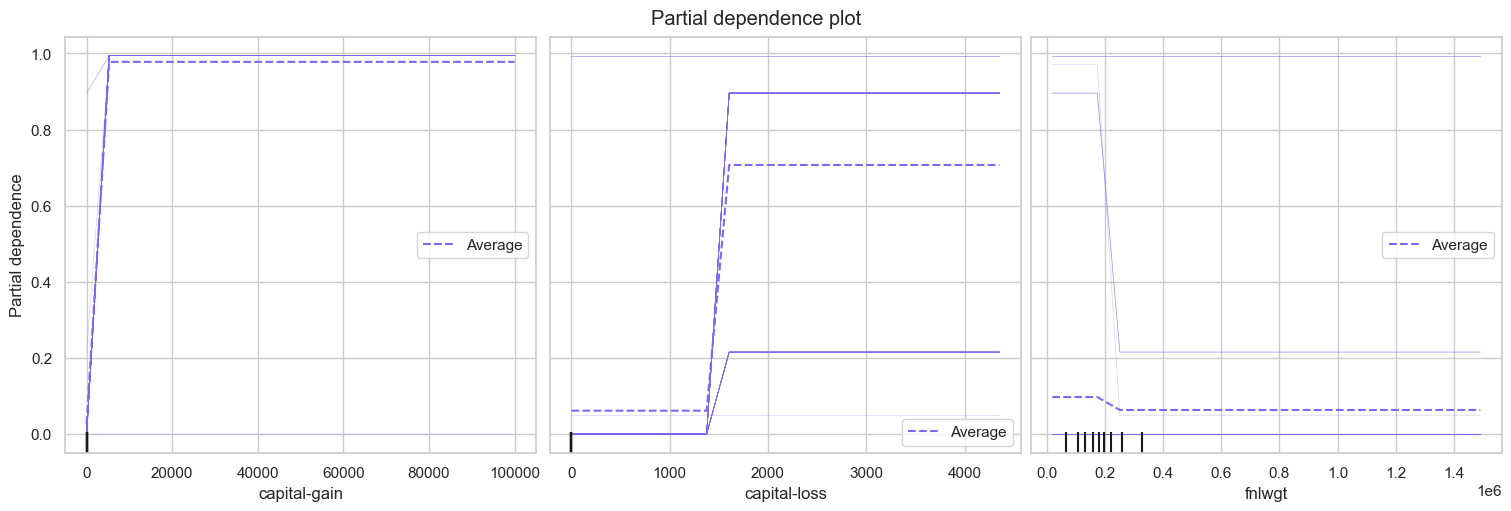

In [17]:
_,ax = plt.subplots(figsize=(15,5))
surrogate_explainer.partial_dependence_plot(last=3, ax=ax, kind='both')

In [18]:
surrogate_explainer.feature_importance_table(sorted_by='Global', top_n=10)

,Global Importance
Variable,
capital-gain,0.685804
capital-loss,0.246726
fnlwgt,0.066089
education_9th,0.001381
native-country_Honduras,0.000000
native-country_Holand-Netherlands,0.000000
native-country_Haiti,0.000000
native-country_Guatemala,0.000000
native-country_Greece,0.000000


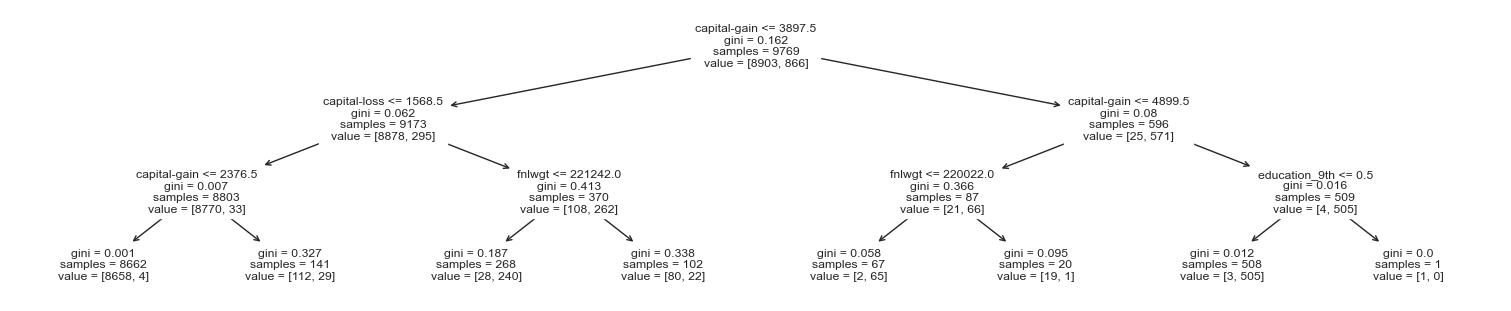

In [19]:
_,ax = plt.subplots(figsize=(15,3))
_ = surrogate_explainer.tree_visualization('sklearn', ax=ax)

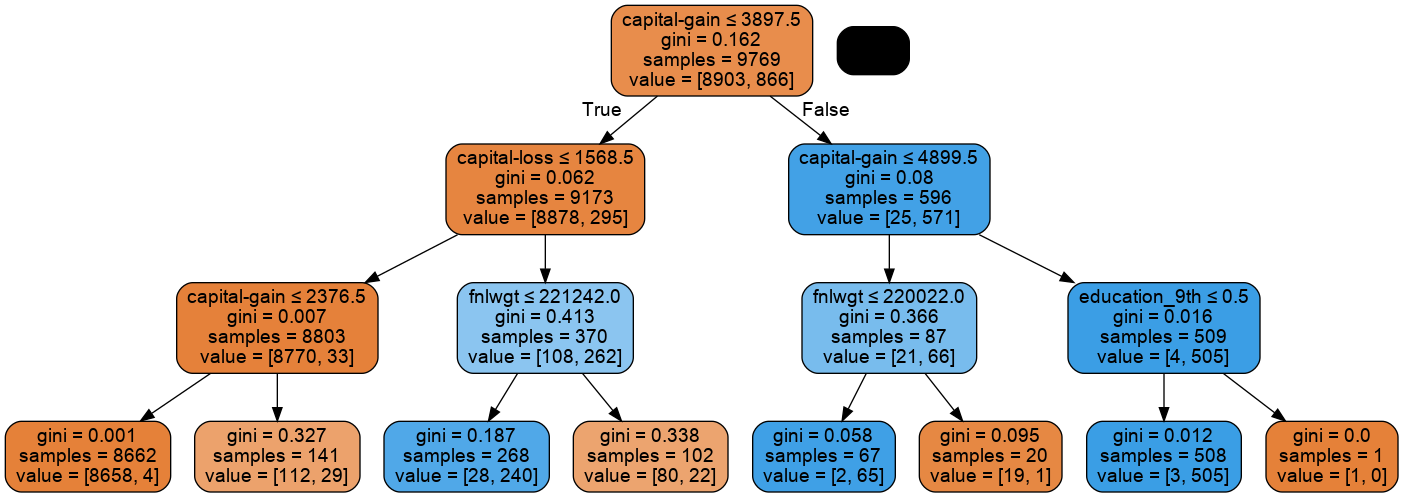

In [20]:
surrogate_explainer.tree_visualization('pydotplus')

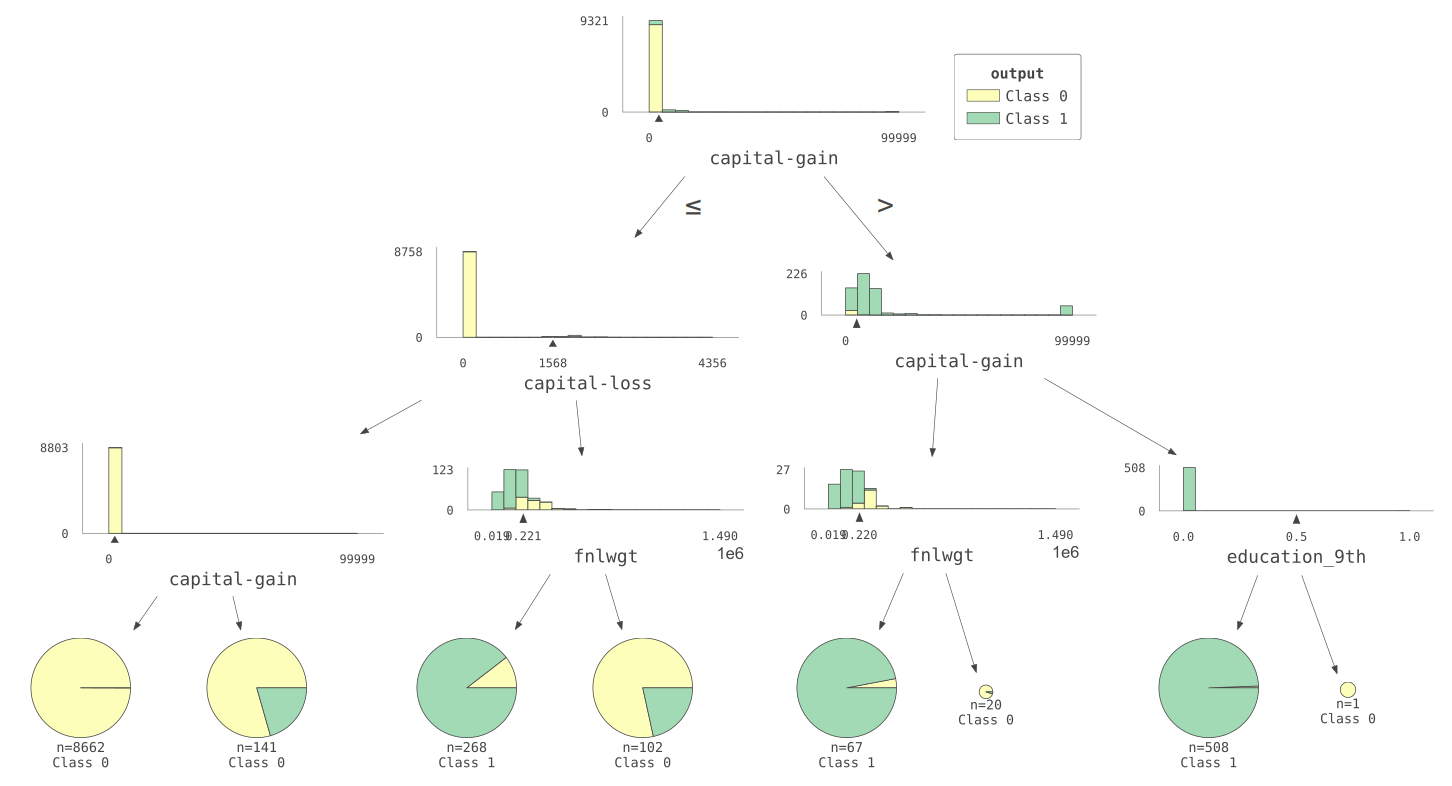

In [21]:
vis = surrogate_explainer.tree_visualization('dtreeviz', scale=2)
vis

# Local Explainability Metrics (based on Lime)

In [22]:
# lime feature importance
lime_explainer = Explainer(based_on='feature_importance',
                      strategy_type='lime',
                      model_type='binary_classification',
                      model = model, 
                      x = X_test, 
                      y = y_test)

In [23]:
lime_explainer.metrics(detailed=False)

,Value,Referemce
Metric,,
Feature Stability,0.040458,0
Data Stability,0.043876,0


In [24]:
lime_explainer.metrics(detailed=True)

,Value,Referemce
Metric,,
Feature Stability,0.040458,0
Feature Stability [label=0],0.048103,0
Feature Stability [label=1],0.047556,0
Data Stability,0.043876,0
Data Stability [label=0],0.046829,0
Data Stability [label=1],0.040780,0


In [25]:
lime_explainer['Data Stability']

0.04387586491054096

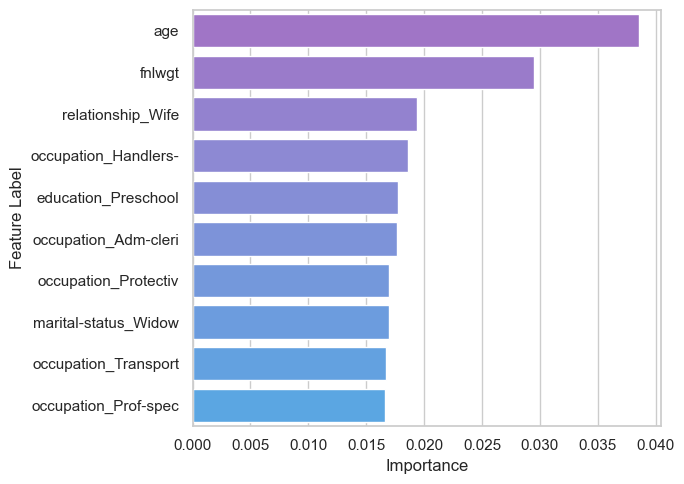

In [26]:
lime_explainer.bar_plot(max_display=10)

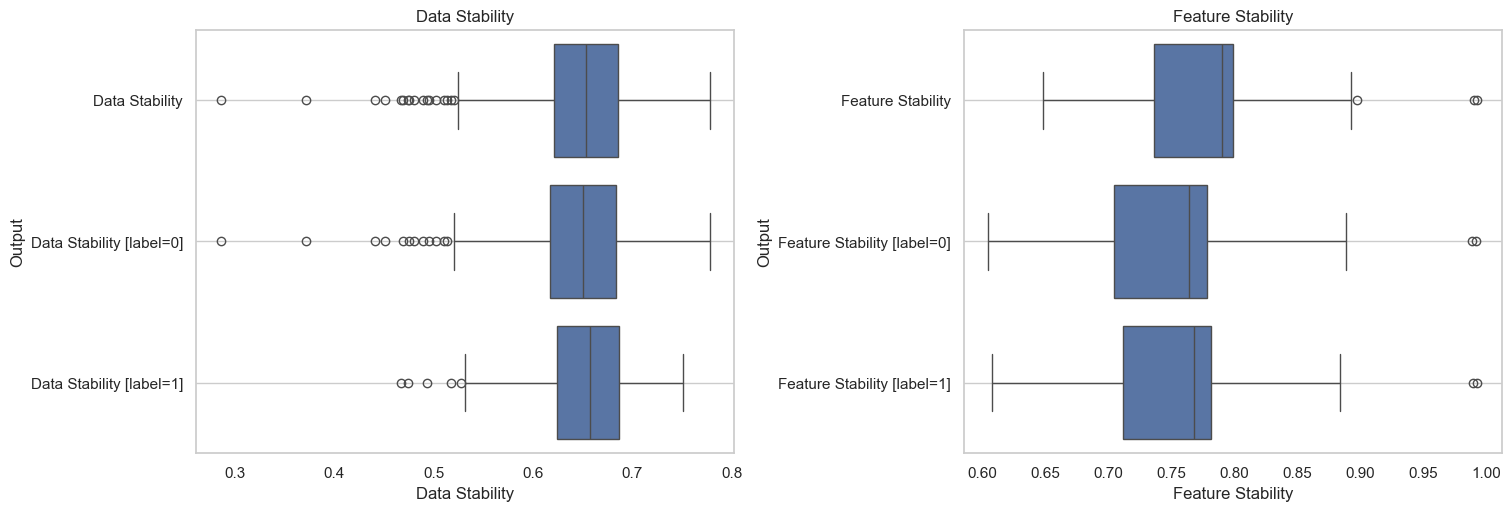

In [27]:
lime_explainer.show_importance_stability()

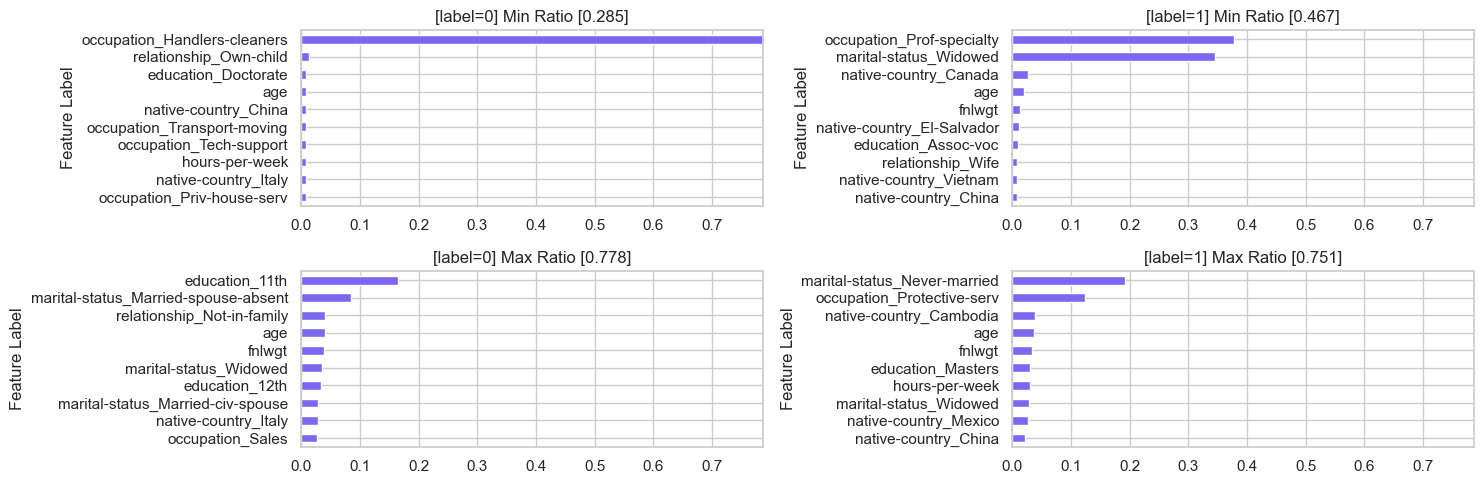

In [28]:
lime_explainer.show_data_stability_boundaries(top_n=10, n_cols=2, figsize=(15,5))

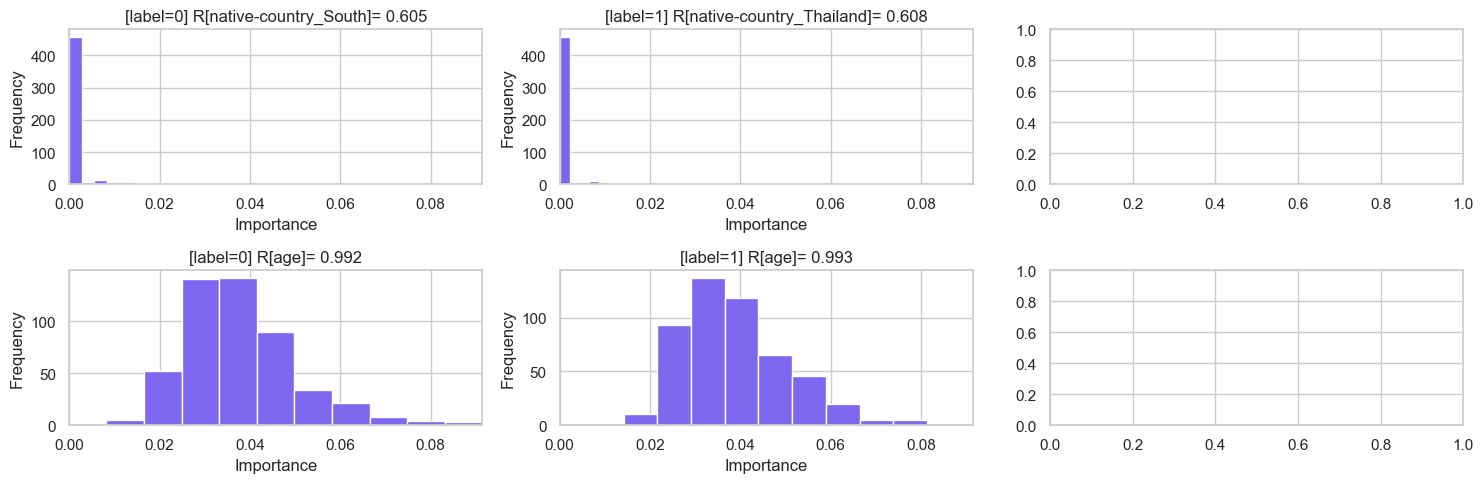

In [29]:
lime_explainer.show_features_stability_boundaries(figsize=(15,5))

# Local Explainability Metrics (SHAP)

In [30]:
# lime feature importance
shap_explainer = Explainer(based_on='feature_importance',
                      strategy_type='shap',
                      model_type='binary_classification',
                      model = model, 
                      x = X_test, 
                      y = y_test)

Permutation explainer: 1001it [00:57, 15.16it/s]                         


In [31]:
shap_explainer.metrics(detailed=False)

,Value,Referemce
Metric,,
Feature Stability,0.114999,0
Data Stability,0.148243,0


In [32]:
shap_explainer['Data Stability']

0.1482428301862122

In [33]:
shap_explainer.metrics(detailed=True)

In [ ]:
shap_explainer.show_importance_stability()

In [ ]:
shap_explainer.show_data_stability_boundaries(top_n=5, figsize=(15,5))

In [ ]:
shap_explainer.show_features_stability_boundaries(figsize=(15,5))